# Imports and defs

In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import copy
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
from torch.autograd import Variable

from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
lr = 0.0002
max_epoch = 10
batch_size = 256
z_dim = 100
image_size = 128
log_step = 100
sample_step = 500
sample_num = 32
IMAGE_PATH = "./celeba/img_align_celeba/"
SAMPLE_PATH = "./samples/"

if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

In [3]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
transform = transforms.Compose(
    [
        # transforms.Scale(image_size),
        transforms.Resize((image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [5]:
dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    drop_last=True,
)

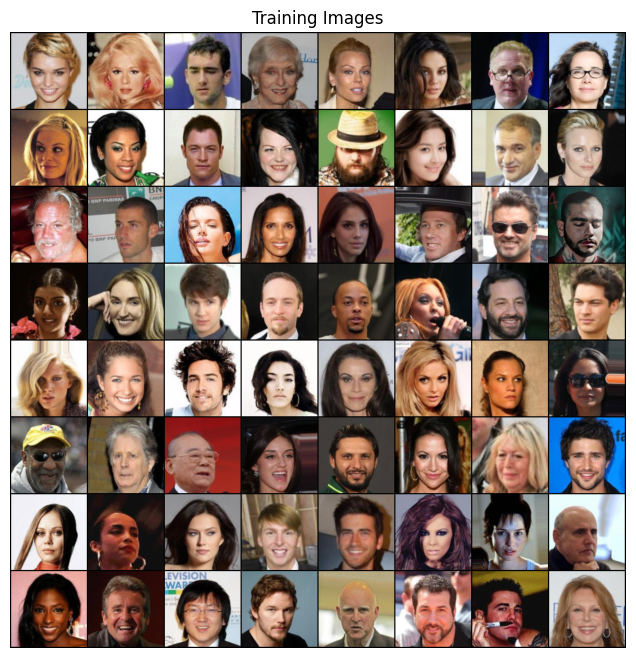

In [6]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Baseline

Стандартная имплементация CSPUp блока (версия 2), обычная реализация без фишек.

In [8]:
class CSPupBlock2(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_,
    ):
        super().__init__()
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_
        self.first = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
        )
        self.second = nn.Sequential(
            nn.Conv2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        return self.first(first_part) + self.second(second_part)

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            CSPupBlock2(
                latent_dim,
                1024,
                k_size=4,
                stride_=1,
                pad_=0,
                bias_=False,
            ),
            CSPupBlock2(
                1024,
                512,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                512,
                256,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                256,
                128,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                128,
                64,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            nn.ConvTranspose2d(
                64,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.ReLU(inplace=True),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.main(z.view(z.size(0), z.size(1), 1, 1))

In [10]:
G = Generator(100)
G.apply(weights_init)
G.cuda()

Generator(
  (main): Sequential(
    (0): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(50, 1024, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): Conv2d(512, 512, kernel_size=(3, 3),

In [11]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                64,
                128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                128,
                256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                256,
                512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                512,
                1024,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                1024,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, img):
        _ = self.main(img)
        return _.view(-1)


D = Discriminator()
D.apply(weights_init)
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [12]:
writer = SummaryWriter()

In [13]:
def wasserstein_loss(real, fake):
    loss = -torch.mean(fake) + torch.mean(real)
    return loss

In [14]:
def train(
    generator,
    discriminator,
    dataloader,
    latent_dim,
    num_epochs,
    g_lr,
    d_lr,
    beta1,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    opt_gen = optim.AdamW(
        generator.parameters(),
        lr=g_lr,
        betas=(beta1, 0.999),
    )
    opt_disc = optim.AdamW(
        discriminator.parameters(),
        lr=d_lr,
    )

    criterion = nn.BCELoss().cuda()
    # criterion = wasserstein_loss

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(tqdm.tqdm(dataloader)):
            imgs = imgs.to(device)
            # valid = torch.ones(imgs.size(0), 1).to(device)
            valid = torch.full(
                (imgs.size(0),), 1.0, dtype=torch.float, device=device
            )
            # fake = torch.zeros(imgs.size(0), 1).to(device)
            fake = torch.full(
                (imgs.size(0),), 0.0, dtype=torch.float, device=device
            )

            noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            fake_imgs = generator(noise)

            opt_disc.zero_grad()
            output = discriminator(imgs)
            errD_real = criterion(output, valid)
            errD_real.backward(retain_graph=True)

            # noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            # fake_imgs = generator(noise)

            output = discriminator(fake_imgs)
            errD_fake = criterion(output, fake)
            errD_fake.backward(retain_graph=True)

            errD = errD_real + errD_fake
            opt_disc.step()
            if i % 10 == 0:
                writer.add_scalar(
                    "Loss/discriminator",
                    errD.item(),
                    len(data_loader) * epoch + i,
                )

            opt_gen.zero_grad()
            output = discriminator(fake_imgs)
            errG = criterion(output, valid)
            errG.backward()
            opt_gen.step()
            if i % 10 == 0:
                generator.eval()
                fake_imgs = generator(fixed_noise).detach().cpu()
                save_image(
                    fake_imgs,
                    f"samples1/fake_images-{epoch}-{i}.png",
                    nrow=8,
                )
                generator.train()
                writer.add_scalar(
                    "Loss/generator",
                    errG.item(),
                    len(data_loader) * epoch + i,
                )
                grid = make_grid(fake_imgs, padding=2, normalize=True)
                writer.add_image("gen_img_vis", grid, i)
            if i % 100 == 0:
                print(
                    f"Iter {i} on epoch_{epoch} | d_loss: {errD.item()} | g_loss: {errG.item()}"
                )
        # print(
        #     f"Epoch {epoch}/{num_epochs} | d_loss: {errD.item()} | g_loss: {errG.item()}"
        # )

        generator.eval()
        fake_imgs = generator(fixed_noise).detach().cpu()
        save_image(fake_imgs, f"samples1/fake_images-{epoch}.png", nrow=8)
        generator.train()

In [15]:
train(
    G,
    D,
    data_loader,
    latent_dim=100,
    num_epochs=17,
    d_lr=0.0002,
    g_lr=0.0002,
    beta1=0.5,
)

  0%|          | 0/791 [00:00<?, ?it/s]

/home/mike/miniconda3/envs/plate_detection/lib/python3.8/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(
  0%|          | 0/791 [00:01<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

Рузультат: разошлось, дискриминатор ушел в 0  
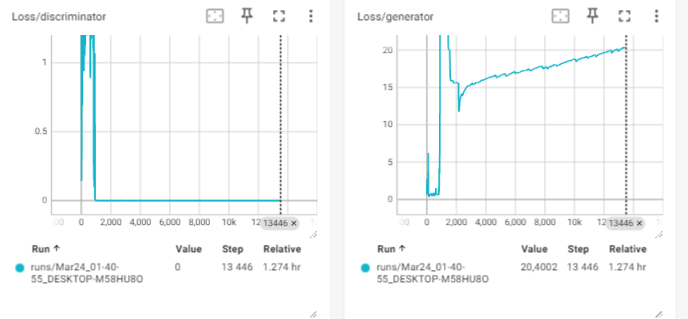

# Add weight decay and increase batch size

1. Добавление L2 регуляризации в дискриминатор и генератор для уменьшения вероятности расхождения из-за огромных весов
2. Увеличение BatchSize для большей выборки обучения генератора (больше, чем 256 на моей GPU не влезло :( )

In [15]:
batch_size = 256

In [16]:
dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    drop_last=True,
)

In [17]:
class CSPupBlock2(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_,
    ):
        super().__init__()
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_
        self.first = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
        )
        self.second = nn.Sequential(
            nn.Conv2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        return self.first(first_part) + self.second(second_part)

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            CSPupBlock2(
                latent_dim,
                1024,
                k_size=4,
                stride_=1,
                pad_=0,
                bias_=False,
            ),
            CSPupBlock2(
                1024,
                512,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                512,
                256,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                256,
                128,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                128,
                64,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            nn.ConvTranspose2d(
                64,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.ReLU(inplace=True),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.main(z.view(z.size(0), z.size(1), 1, 1))

In [19]:
G = Generator(100)
G.apply(weights_init)
G.cuda()

Generator(
  (main): Sequential(
    (0): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(50, 1024, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): Conv2d(512, 512, kernel_size=(3, 3),

In [20]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                64,
                128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                128,
                256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                256,
                512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                512,
                1024,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.Conv2d(
                1024,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, img):
        _ = self.main(img)
        return _.view(-1)


D = Discriminator()
D.apply(weights_init)
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [21]:
writer = SummaryWriter()

In [22]:
def wasserstein_loss(real, fake):
    loss = -torch.mean(fake) + torch.mean(real)
    return loss

In [23]:
def train(
    generator,
    discriminator,
    dataloader,
    latent_dim,
    num_epochs,
    g_lr,
    d_lr,
    g_wd,
    d_wd,
    beta1,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    opt_gen = optim.AdamW(
        generator.parameters(),
        lr=g_lr,
        betas=(beta1, 0.999),
        weight_decay=g_wd,
    )
    opt_disc = optim.AdamW(
        discriminator.parameters(),
        lr=d_lr,
        weight_decay=d_wd,
    )

    criterion = nn.BCELoss().cuda()
    # criterion = wasserstein_loss

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(tqdm.tqdm(dataloader)):
            imgs = imgs.to(device)
            # valid = torch.ones(imgs.size(0), 1).to(device)
            valid = torch.full(
                (imgs.size(0),), 1.0, dtype=torch.float, device=device
            )
            # fake = torch.zeros(imgs.size(0), 1).to(device)
            fake = torch.full(
                (imgs.size(0),), 0.0, dtype=torch.float, device=device
            )

            noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            fake_imgs = generator(noise)

            opt_disc.zero_grad()
            output = discriminator(imgs)
            errD_real = criterion(output, valid)
            errD_real.backward(retain_graph=True)

            # noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            # fake_imgs = generator(noise)

            output = discriminator(fake_imgs)
            errD_fake = criterion(output, fake)
            errD_fake.backward(retain_graph=True)

            errD = errD_real + errD_fake
            opt_disc.step()
            if i % 10 == 0:
                writer.add_scalar(
                    "Loss/discriminator",
                    errD.item(),
                    len(data_loader) * epoch + i,
                )

            opt_gen.zero_grad()
            output = discriminator(fake_imgs)
            errG = criterion(output, valid)
            errG.backward()
            opt_gen.step()
            if i % 10 == 0:
                generator.eval()
                fake_imgs = generator(fixed_noise).detach().cpu()
                save_image(
                    fake_imgs,
                    f"samples2/fake_images-{epoch}-{i}.png",
                    nrow=8,
                )
                generator.train()
                writer.add_scalar(
                    "Loss/generator",
                    errG.item(),
                    len(data_loader) * epoch + i,
                )
                grid = make_grid(fake_imgs, padding=2, normalize=True)
                writer.add_image("gen_img_vis", grid, i)
            if i % 100 == 0:
                print(
                    f"Iter {i} on epoch_{epoch} | d_loss: {errD.item()} | g_loss: {errG.item()}"
                )
        # print(
        #     f"Epoch {epoch}/{num_epochs} | d_loss: {errD.item()} | g_loss: {errG.item()}"
        # )

        generator.eval()
        fake_imgs = generator(fixed_noise).detach().cpu()
        save_image(fake_imgs, f"samples2/fake_images-{epoch}.png", nrow=8)
        generator.train()

In [25]:
train(
    G,
    D,
    data_loader,
    latent_dim=100,
    num_epochs=17,
    d_lr=0.0002,
    g_lr=0.0002,
    g_wd=0.3,
    d_wd=0.01,
    beta1=0.5,
)

  0%|          | 1/791 [00:02<32:01,  2.43s/it]

Iter 0 on epoch_0 | d_loss: 1.3843929767608643 | g_loss: 0.6857696175575256


 10%|█         | 80/791 [00:39<03:46,  3.15it/s]

 13%|█▎        | 101/791 [00:51<07:55,  1.45it/s]

Iter 100 on epoch_0 | d_loss: 4.655160427093506 | g_loss: 0.030545596033334732


 25%|██▌       | 201/791 [01:36<06:56,  1.42it/s]

Iter 200 on epoch_0 | d_loss: 3.8533949851989746 | g_loss: 0.28175097703933716


 38%|███▊      | 301/791 [02:22<05:39,  1.44it/s]

Iter 300 on epoch_0 | d_loss: 1.6265064477920532 | g_loss: 1.0402637720108032


 51%|█████     | 401/791 [03:08<04:29,  1.45it/s]

Iter 400 on epoch_0 | d_loss: 1.4087507724761963 | g_loss: 0.6295282244682312


 63%|██████▎   | 501/791 [03:53<03:17,  1.47it/s]

Iter 500 on epoch_0 | d_loss: 1.6370368003845215 | g_loss: 0.5763903856277466


 76%|███████▌  | 601/791 [04:39<02:04,  1.53it/s]

Iter 600 on epoch_0 | d_loss: 1.2668051719665527 | g_loss: 0.7556509971618652


 89%|████████▊ | 701/791 [05:24<01:04,  1.39it/s]

Iter 700 on epoch_0 | d_loss: 1.6008402109146118 | g_loss: 0.6465716361999512


  0%|          | 1/791 [00:02<29:52,  2.27s/it]

Iter 0 on epoch_1 | d_loss: 1.3611841201782227 | g_loss: 0.6922752261161804


 13%|█▎        | 101/791 [00:47<08:02,  1.43it/s]

Iter 100 on epoch_1 | d_loss: 1.2819427251815796 | g_loss: 0.7179355025291443


 25%|██▌       | 201/791 [01:33<06:41,  1.47it/s]

Iter 200 on epoch_1 | d_loss: 1.3240193128585815 | g_loss: 1.031392216682434


 38%|███▊      | 301/791 [02:19<06:15,  1.30it/s]

Iter 300 on epoch_1 | d_loss: 1.3635575771331787 | g_loss: 0.7390202283859253


 51%|█████     | 401/791 [03:05<04:44,  1.37it/s]

Iter 400 on epoch_1 | d_loss: 0.7090863585472107 | g_loss: 2.275406837463379


 63%|██████▎   | 501/791 [03:51<03:25,  1.41it/s]

Iter 500 on epoch_1 | d_loss: 1.201996088027954 | g_loss: 0.9523273706436157


 76%|███████▌  | 601/791 [04:37<02:26,  1.29it/s]

Iter 600 on epoch_1 | d_loss: 1.3441362380981445 | g_loss: 0.913211464881897


 89%|████████▊ | 701/791 [05:23<01:03,  1.41it/s]

Iter 700 on epoch_1 | d_loss: 1.4817135334014893 | g_loss: 0.6833101511001587


  0%|          | 1/791 [00:02<28:43,  2.18s/it]

Iter 0 on epoch_2 | d_loss: 1.4021822214126587 | g_loss: 0.6988717913627625


 13%|█▎        | 101/791 [00:47<07:54,  1.45it/s]

Iter 100 on epoch_2 | d_loss: 1.305637240409851 | g_loss: 0.6124242544174194


 25%|██▌       | 201/791 [01:34<07:00,  1.40it/s]

Iter 200 on epoch_2 | d_loss: 1.3474550247192383 | g_loss: 0.6691573858261108


 38%|███▊      | 301/791 [02:18<06:17,  1.30it/s]

Iter 300 on epoch_2 | d_loss: 1.496849536895752 | g_loss: 0.6343352198600769


 51%|█████     | 401/791 [03:05<05:00,  1.30it/s]

Iter 400 on epoch_2 | d_loss: 1.3426055908203125 | g_loss: 0.7894020676612854


 63%|██████▎   | 501/791 [03:51<03:24,  1.42it/s]

Iter 500 on epoch_2 | d_loss: 1.2594441175460815 | g_loss: 1.0577629804611206


 76%|███████▌  | 601/791 [04:36<02:26,  1.30it/s]

Iter 600 on epoch_2 | d_loss: 1.615156888961792 | g_loss: 0.5934299230575562


 89%|████████▊ | 701/791 [05:23<01:08,  1.32it/s]

Iter 700 on epoch_2 | d_loss: 1.280954360961914 | g_loss: 0.7179596424102783


  0%|          | 1/791 [00:02<28:24,  2.16s/it]

Iter 0 on epoch_3 | d_loss: 1.4898707866668701 | g_loss: 0.7351577281951904


 13%|█▎        | 101/791 [00:48<08:16,  1.39it/s]

Iter 100 on epoch_3 | d_loss: 1.3466486930847168 | g_loss: 0.7155787944793701


 25%|██▌       | 201/791 [01:34<07:20,  1.34it/s]

Iter 200 on epoch_3 | d_loss: 1.521824836730957 | g_loss: 0.5711846947669983


 38%|███▊      | 301/791 [02:20<05:48,  1.41it/s]

Iter 300 on epoch_3 | d_loss: 1.5183687210083008 | g_loss: 0.5840718746185303


 51%|█████     | 401/791 [03:05<04:31,  1.44it/s]

Iter 400 on epoch_3 | d_loss: 1.6303739547729492 | g_loss: 0.617322564125061


 63%|██████▎   | 501/791 [03:51<03:24,  1.42it/s]

Iter 500 on epoch_3 | d_loss: 1.3201977014541626 | g_loss: 0.7304441928863525


 76%|███████▌  | 601/791 [04:36<02:18,  1.38it/s]

Iter 600 on epoch_3 | d_loss: 1.3335132598876953 | g_loss: 0.7243494391441345


 89%|████████▊ | 701/791 [05:22<01:08,  1.32it/s]

Iter 700 on epoch_3 | d_loss: 1.4163681268692017 | g_loss: 0.6689634919166565


  0%|          | 1/791 [00:02<26:45,  2.03s/it]

Iter 0 on epoch_4 | d_loss: 1.2940168380737305 | g_loss: 0.7074168920516968


 13%|█▎        | 101/791 [00:48<08:01,  1.43it/s]

Iter 100 on epoch_4 | d_loss: 1.9556541442871094 | g_loss: 0.9955108761787415


 25%|██▌       | 201/791 [01:33<06:35,  1.49it/s]

Iter 200 on epoch_4 | d_loss: 1.9068970680236816 | g_loss: 0.7592994570732117


 38%|███▊      | 301/791 [02:18<05:32,  1.48it/s]

Iter 300 on epoch_4 | d_loss: 1.3831496238708496 | g_loss: 0.624245822429657


 51%|█████     | 401/791 [03:03<04:26,  1.46it/s]

Iter 400 on epoch_4 | d_loss: 1.2565839290618896 | g_loss: 0.8755652904510498


 63%|██████▎   | 501/791 [03:49<03:32,  1.36it/s]

Iter 500 on epoch_4 | d_loss: 1.2709509134292603 | g_loss: 0.8245227932929993


 76%|███████▌  | 601/791 [04:35<02:19,  1.37it/s]

Iter 600 on epoch_4 | d_loss: 1.3326292037963867 | g_loss: 0.6757338047027588


 89%|████████▊ | 701/791 [05:20<01:06,  1.35it/s]

Iter 700 on epoch_4 | d_loss: 1.2556405067443848 | g_loss: 0.7101548910140991


  0%|          | 1/791 [00:02<27:26,  2.08s/it]

Iter 0 on epoch_5 | d_loss: 1.451432228088379 | g_loss: 0.8202459812164307


 13%|█▎        | 101/791 [00:47<07:57,  1.45it/s]

Iter 100 on epoch_5 | d_loss: 1.3597303628921509 | g_loss: 0.6860383749008179


 25%|██▌       | 201/791 [01:32<07:16,  1.35it/s]

Iter 200 on epoch_5 | d_loss: 1.9173893928527832 | g_loss: 0.9451011419296265


 38%|███▊      | 301/791 [02:17<05:45,  1.42it/s]

Iter 300 on epoch_5 | d_loss: 1.4038784503936768 | g_loss: 0.75614333152771


 51%|█████     | 401/791 [03:02<04:35,  1.42it/s]

Iter 400 on epoch_5 | d_loss: 1.4667671918869019 | g_loss: 0.9993420243263245


 63%|██████▎   | 501/791 [03:47<03:20,  1.44it/s]

Iter 500 on epoch_5 | d_loss: 1.5885341167449951 | g_loss: 0.6146857738494873


 76%|███████▌  | 601/791 [04:32<02:16,  1.39it/s]

Iter 600 on epoch_5 | d_loss: 1.364795207977295 | g_loss: 0.6627891659736633


 89%|████████▊ | 701/791 [05:18<01:05,  1.38it/s]

Iter 700 on epoch_5 | d_loss: 1.4385712146759033 | g_loss: 0.7378544807434082


  0%|          | 1/791 [00:02<36:36,  2.78s/it]

Iter 0 on epoch_6 | d_loss: 1.3422694206237793 | g_loss: 0.7229291796684265


 13%|█▎        | 101/791 [00:47<08:03,  1.43it/s]

Iter 100 on epoch_6 | d_loss: 1.4458342790603638 | g_loss: 0.656495213508606


 25%|██▌       | 201/791 [01:33<07:12,  1.37it/s]

Iter 200 on epoch_6 | d_loss: 1.498765230178833 | g_loss: 0.6561988592147827


 38%|███▊      | 301/791 [02:20<06:00,  1.36it/s]

Iter 300 on epoch_6 | d_loss: 1.3582651615142822 | g_loss: 0.7504192590713501


 51%|█████     | 401/791 [03:07<05:07,  1.27it/s]

Iter 400 on epoch_6 | d_loss: 1.4005887508392334 | g_loss: 0.7158710956573486


 63%|██████▎   | 501/791 [03:54<03:43,  1.30it/s]

Iter 500 on epoch_6 | d_loss: 1.3129098415374756 | g_loss: 0.6197301149368286


 76%|███████▌  | 601/791 [04:41<02:10,  1.45it/s]

Iter 600 on epoch_6 | d_loss: 1.5676157474517822 | g_loss: 0.6790772080421448


 89%|████████▊ | 701/791 [05:26<01:04,  1.40it/s]

Iter 700 on epoch_6 | d_loss: 1.4317762851715088 | g_loss: 0.7656837701797485


  0%|          | 1/791 [00:02<27:50,  2.11s/it]

Iter 0 on epoch_7 | d_loss: 1.2860662937164307 | g_loss: 0.6578935384750366


 13%|█▎        | 101/791 [00:47<07:40,  1.50it/s]

Iter 100 on epoch_7 | d_loss: 1.388563632965088 | g_loss: 0.7717514634132385


 25%|██▌       | 201/791 [01:32<06:57,  1.41it/s]

Iter 200 on epoch_7 | d_loss: 1.394862174987793 | g_loss: 0.744550883769989


 38%|███▊      | 301/791 [02:18<06:01,  1.35it/s]

Iter 300 on epoch_7 | d_loss: 1.3319268226623535 | g_loss: 0.6678769588470459


 51%|█████     | 401/791 [03:04<05:01,  1.30it/s]

Iter 400 on epoch_7 | d_loss: 1.3617141246795654 | g_loss: 0.7884451150894165


 63%|██████▎   | 501/791 [03:49<03:33,  1.36it/s]

Iter 500 on epoch_7 | d_loss: 1.4369277954101562 | g_loss: 0.7424389123916626


 76%|███████▌  | 601/791 [04:34<02:13,  1.43it/s]

Iter 600 on epoch_7 | d_loss: 1.8860394954681396 | g_loss: 0.8821285963058472


 89%|████████▊ | 701/791 [05:22<01:12,  1.25it/s]

Iter 700 on epoch_7 | d_loss: 1.3750801086425781 | g_loss: 0.7257732152938843


  0%|          | 1/791 [00:02<29:58,  2.28s/it]

Iter 0 on epoch_8 | d_loss: 1.4633687734603882 | g_loss: 0.749927818775177


 13%|█▎        | 101/791 [00:48<07:38,  1.50it/s]

Iter 100 on epoch_8 | d_loss: 1.4064433574676514 | g_loss: 0.6770312786102295


 25%|██▌       | 201/791 [01:34<08:05,  1.22it/s]

Iter 200 on epoch_8 | d_loss: 1.3561358451843262 | g_loss: 0.5589581727981567


 38%|███▊      | 301/791 [02:19<05:41,  1.43it/s]

Iter 300 on epoch_8 | d_loss: 1.458754062652588 | g_loss: 0.6389304399490356


 51%|█████     | 401/791 [03:05<04:40,  1.39it/s]

Iter 400 on epoch_8 | d_loss: 1.2336236238479614 | g_loss: 0.5532354712486267


 63%|██████▎   | 501/791 [03:52<03:50,  1.26it/s]

Iter 500 on epoch_8 | d_loss: 1.5258445739746094 | g_loss: 0.8663667440414429


 76%|███████▌  | 601/791 [04:38<02:16,  1.39it/s]

Iter 600 on epoch_8 | d_loss: 1.3754181861877441 | g_loss: 0.7592920064926147


 89%|████████▊ | 701/791 [05:23<01:03,  1.42it/s]

Iter 700 on epoch_8 | d_loss: 1.4308747053146362 | g_loss: 0.8523768186569214


  0%|          | 1/791 [00:02<28:24,  2.16s/it]

Iter 0 on epoch_9 | d_loss: 1.3732664585113525 | g_loss: 0.7753576636314392


 13%|█▎        | 101/791 [00:46<08:17,  1.39it/s]

Iter 100 on epoch_9 | d_loss: 1.411243200302124 | g_loss: 0.7437787652015686


 25%|██▌       | 201/791 [01:32<07:04,  1.39it/s]

Iter 200 on epoch_9 | d_loss: 1.3471834659576416 | g_loss: 0.6653704643249512


 38%|███▊      | 301/791 [02:18<06:04,  1.34it/s]

Iter 300 on epoch_9 | d_loss: 1.2661256790161133 | g_loss: 0.9514188766479492


 51%|█████     | 401/791 [03:04<05:01,  1.29it/s]

Iter 400 on epoch_9 | d_loss: 1.4393737316131592 | g_loss: 0.7214187383651733


 63%|██████▎   | 501/791 [03:49<03:26,  1.40it/s]

Iter 500 on epoch_9 | d_loss: 1.3904054164886475 | g_loss: 0.7980526089668274


 76%|███████▌  | 601/791 [04:35<02:24,  1.31it/s]

Iter 600 on epoch_9 | d_loss: 1.4121812582015991 | g_loss: 0.7281544208526611


 89%|████████▊ | 702/791 [05:19<00:40,  2.22it/s]

Iter 700 on epoch_9 | d_loss: 1.451462745666504 | g_loss: 0.5042949914932251


  0%|          | 1/791 [00:01<18:41,  1.42s/it]

Iter 0 on epoch_10 | d_loss: 0.010709411464631557 | g_loss: 13.09418773651123


 13%|█▎        | 101/791 [00:35<05:58,  1.92it/s]

Iter 100 on epoch_10 | d_loss: 100.00001525878906 | g_loss: 0.0


 25%|██▌       | 201/791 [01:08<05:05,  1.93it/s]

Iter 200 on epoch_10 | d_loss: 100.00004577636719 | g_loss: 0.0


 38%|███▊      | 301/791 [01:42<04:13,  1.93it/s]

Iter 300 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:16<03:20,  1.95it/s]

Iter 400 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:50<02:27,  1.96it/s]

Iter 500 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:24<01:40,  1.89it/s]

Iter 600 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [03:58<00:46,  1.93it/s]

Iter 700 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<18:36,  1.41s/it]

Iter 0 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:35<06:00,  1.91it/s]

Iter 100 on epoch_11 | d_loss: 100.00000762939453 | g_loss: 0.0


 25%|██▌       | 201/791 [01:08<05:02,  1.95it/s]

Iter 200 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [01:42<04:09,  1.96it/s]

Iter 300 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:16<03:17,  1.97it/s]

Iter 400 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:50<02:28,  1.95it/s]

Iter 500 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:24<01:38,  1.94it/s]

Iter 600 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [03:58<00:46,  1.95it/s]

Iter 700 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<19:19,  1.47s/it]

Iter 0 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:35<06:03,  1.90it/s]

Iter 100 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:09<05:07,  1.92it/s]

Iter 200 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [01:43<04:16,  1.91it/s]

Iter 300 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:17<03:21,  1.93it/s]

Iter 400 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:51<02:31,  1.91it/s]

Iter 500 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:25<01:38,  1.93it/s]

Iter 600 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [03:59<00:47,  1.91it/s]

Iter 700 on epoch_12 | d_loss: 100.00000762939453 | g_loss: 0.0


  0%|          | 1/791 [00:01<18:53,  1.44s/it]

Iter 0 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:35<05:57,  1.93it/s]

Iter 100 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:09<05:08,  1.91it/s]

Iter 200 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [01:43<04:24,  1.85it/s]

Iter 300 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:17<03:27,  1.88it/s]

Iter 400 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:52<02:29,  1.95it/s]

Iter 500 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:25<01:39,  1.92it/s]

Iter 600 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [04:00<00:47,  1.89it/s]

Iter 700 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<19:13,  1.46s/it]

Iter 0 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:35<06:01,  1.91it/s]

Iter 100 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:09<05:06,  1.92it/s]

Iter 200 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [01:43<04:13,  1.93it/s]

Iter 300 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:17<03:23,  1.91it/s]

Iter 400 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:51<02:30,  1.92it/s]

Iter 500 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:26<01:39,  1.91it/s]

Iter 600 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [04:00<00:46,  1.94it/s]

Iter 700 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<19:12,  1.46s/it]

Iter 0 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:35<06:03,  1.90it/s]

Iter 100 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:09<05:10,  1.90it/s]

Iter 200 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [01:43<04:19,  1.89it/s]

Iter 300 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:17<03:17,  1.97it/s]

Iter 400 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:51<02:30,  1.93it/s]

Iter 500 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:25<01:37,  1.96it/s]

Iter 600 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [03:59<00:46,  1.94it/s]

Iter 700 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<18:45,  1.42s/it]

Iter 0 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:35<06:02,  1.90it/s]

Iter 100 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:09<05:03,  1.95it/s]

Iter 200 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [01:43<04:14,  1.92it/s]

Iter 300 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:17<03:23,  1.92it/s]

Iter 400 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [02:51<02:31,  1.91it/s]

Iter 500 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [03:25<01:38,  1.93it/s]

Iter 600 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [03:59<00:47,  1.90it/s]

Iter 700 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


100%|██████████| 791/791 [04:30<00:00,  2.92it/s]


Результат: по loss'ам все шло стабильно до 11 эпохи  
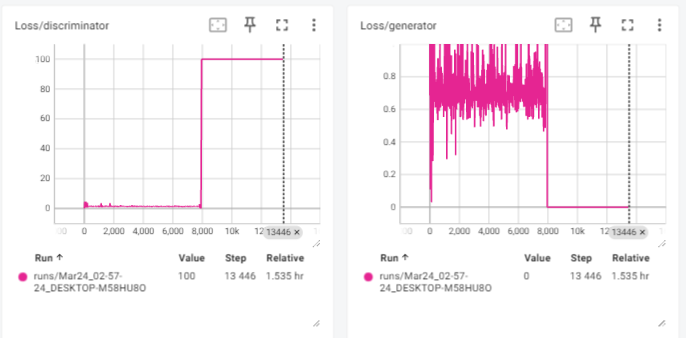  
По изображениям можно сказать, что все шло плохо  
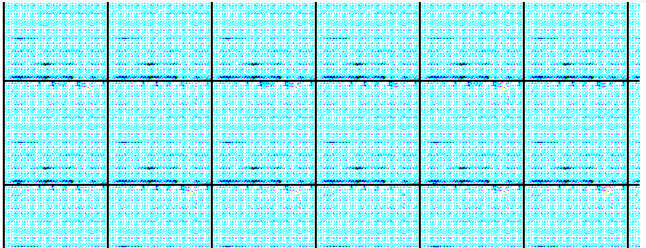

# LeakyRelu and BatchNorm

1. Добавление LeakyRelu, так как во многих гайдах обучения GAN советуют заменять ReLU на LeakyReL в дискриминаторе и генераторе для уменьшения вероятности расхождения
2. Добавление BatchNorm для нормализации батча между свертками

In [24]:
batch_size = 256

In [25]:
dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    drop_last=True,
)

In [38]:
class CSPupBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_=False,
    ):
        super(CSPupBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_

        self.deconv_layer1 = nn.ConvTranspose2d(
            in_channels // 2,
            self.out_channels,
            kernel_size=self.k_size,
            stride=self.stride_,
            padding=self.pad_,
            bias=bias_,
        )

        self.deconv_layer2 = nn.ConvTranspose2d(
            in_channels // 2,
            self.out_channels,
            kernel_size=self.k_size,
            stride=self.stride_,
            padding=self.pad_,
            bias=self.bias_,
        )

        self.conv1 = nn.Conv2d(
            in_channels // 2,
            in_channels // 2,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            self.out_channels,
            self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.relu2 = nn.LeakyReLU(inplace=True)

        self.conv3 = nn.Conv2d(
            self.out_channels,
            self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        first_part = self.deconv_layer1(first_part)

        second_part = self.conv1(second_part)
        second_part = self.relu1(second_part)
        second_part = self.deconv_layer2(second_part)
        second_part = self.conv2(second_part)
        second_part = self.relu2(second_part)
        second_part = self.conv3(second_part)

        return first_part + second_part

In [39]:
class CSPupBlock2(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_,
    ):
        super().__init__()
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_
        self.first = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
        )
        self.second = nn.Sequential(
            nn.Conv2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        return self.first(first_part) + self.second(second_part)

In [40]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            CSPupBlock2(
                latent_dim,
                1024,
                k_size=4,
                stride_=1,
                pad_=0,
                bias_=False,
            ),
            CSPupBlock2(
                1024,
                512,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                512,
                256,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                256,
                128,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                128,
                64,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            nn.ConvTranspose2d(
                64,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.ReLU(inplace=True),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.main(z.view(z.size(0), z.size(1), 1, 1))

In [41]:
G = Generator(100)
G.apply(weights_init)
G.cuda()

Generator(
  (main): Sequential(
    (0): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(50, 1024, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): LeakyReLU(negative_slope=0.1)
        (7): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (second): Sequential(


In [42]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                64,
                128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                128,
                256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                256,
                512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                512,
                1024,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                1024,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, img):
        _ = self.main(img)
        return _.view(-1)


D = Discriminator()
D.apply(weights_init)
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(512, 1024, kernel_siz

In [43]:
writer = SummaryWriter()

In [44]:
def wasserstein_loss(real, fake):
    loss = -torch.mean(fake) + torch.mean(real)
    return loss

In [45]:
def train(
    generator,
    discriminator,
    dataloader,
    latent_dim,
    num_epochs,
    g_lr,
    d_lr,
    g_wd,
    d_wd,
    beta1,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    opt_gen = optim.AdamW(
        generator.parameters(),
        lr=g_lr,
        betas=(beta1, 0.999),
        weight_decay=g_wd,
    )
    opt_disc = optim.AdamW(
        discriminator.parameters(),
        lr=d_lr,
        weight_decay=d_wd,
    )

    criterion = nn.BCELoss().cuda()
    # criterion = wasserstein_loss

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(tqdm.tqdm(dataloader)):
            imgs = imgs.to(device)
            # valid = torch.ones(imgs.size(0), 1).to(device)
            valid = torch.full(
                (imgs.size(0),), 1.0, dtype=torch.float, device=device
            )
            # fake = torch.zeros(imgs.size(0), 1).to(device)
            fake = torch.full(
                (imgs.size(0),), 0.0, dtype=torch.float, device=device
            )

            noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            fake_imgs = generator(noise)

            # if epoch % 2 == 0:
            opt_disc.zero_grad()
            output = discriminator(imgs)
            errD_real = criterion(output, valid)
            errD_real.backward(retain_graph=True)

            # noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            # fake_imgs = generator(noise)

            output = discriminator(fake_imgs)
            errD_fake = criterion(output, fake)
            errD_fake.backward(retain_graph=True)

            errD = errD_real + errD_fake
            opt_disc.step()
            if i % 10 == 0:
                writer.add_scalar(
                    "Loss/discriminator",
                    errD.item(),
                    len(data_loader) * epoch + i,
                )

            opt_gen.zero_grad()
            output = discriminator(fake_imgs)
            errG = criterion(output, valid)
            errG.backward()
            opt_gen.step()
            if i % 10 == 0:
                generator.eval()
                fake_imgs = generator(fixed_noise).detach().cpu()
                save_image(
                    fake_imgs,
                    f"samples3/fake_images-{epoch}-{i}.png",
                    nrow=8,
                )
                generator.train()
                writer.add_scalar(
                    "Loss/generator",
                    errG.item(),
                    len(data_loader) * epoch + i,
                )
                grid = make_grid(fake_imgs, padding=2, normalize=True)
                writer.add_image("gen_img_vis", grid, i)
            if i % 100 == 0:
                print(
                    f"Iter {i} on epoch_{epoch} | d_loss: {errD.item()} | g_loss: {errG.item()}"
                )
        # print(
        #     f"Epoch {epoch}/{num_epochs} | d_loss: {errD.item()} | g_loss: {errG.item()}"
        # )

        generator.eval()
        fake_imgs = generator(fixed_noise).detach().cpu()
        save_image(fake_imgs, f"samples3/fake_images-{epoch}.png", nrow=8)
        generator.train()

In [36]:
train(
    G,
    D,
    data_loader,
    latent_dim=100,
    num_epochs=17,
    d_lr=0.0002,
    g_lr=0.0002,
    d_wd=0.01,
    g_wd=0.4,
    beta1=0.5,
)

  0%|          | 1/791 [00:02<28:16,  2.15s/it]

Iter 0 on epoch_0 | d_loss: 2.007401704788208 | g_loss: 4.325716018676758


  7%|▋         | 57/791 [00:32<05:23,  2.27it/s]

 13%|█▎        | 101/791 [00:58<11:00,  1.04it/s]

Iter 100 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:58<09:28,  1.04it/s]

Iter 200 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:57<07:53,  1.04it/s]

Iter 300 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:56<06:09,  1.06it/s]

Iter 400 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:55<04:41,  1.03it/s]

Iter 500 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:54<03:00,  1.05it/s]

Iter 600 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:53<01:24,  1.06it/s]

Iter 700 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<36:11,  2.75s/it]

Iter 0 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [01:01<10:48,  1.06it/s]

Iter 100 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:59<09:09,  1.07it/s]

Iter 200 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:57<07:44,  1.05it/s]

Iter 300 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:56<06:04,  1.07it/s]

Iter 400 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:54<04:29,  1.07it/s]

Iter 500 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:53<02:58,  1.06it/s]

Iter 600 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:51<01:24,  1.06it/s]

Iter 700 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<35:35,  2.70s/it]

Iter 0 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [01:01<10:39,  1.08it/s]

Iter 100 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:58<09:01,  1.09it/s]

Iter 200 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:56<07:33,  1.08it/s]

Iter 300 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:54<05:57,  1.09it/s]

Iter 400 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:52<04:24,  1.10it/s]

Iter 500 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:50<02:52,  1.10it/s]

Iter 600 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:48<01:21,  1.10it/s]

Iter 700 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<34:33,  2.63s/it]

Iter 0 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [01:00<10:27,  1.10it/s]

Iter 100 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:57<08:57,  1.10it/s]

Iter 200 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:55<07:22,  1.11it/s]

Iter 300 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:52<05:54,  1.10it/s]

Iter 400 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:50<04:23,  1.10it/s]

Iter 500 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:47<02:52,  1.10it/s]

Iter 600 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:44<01:20,  1.12it/s]

Iter 700 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<34:54,  2.65s/it]

Iter 0 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [01:00<10:19,  1.11it/s]

Iter 100 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:57<08:50,  1.11it/s]

Iter 200 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:54<07:22,  1.11it/s]

Iter 300 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:52<05:48,  1.12it/s]

Iter 400 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:49<04:23,  1.10it/s]

Iter 500 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:46<02:49,  1.12it/s]

Iter 600 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:43<01:22,  1.10it/s]

Iter 700 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<34:14,  2.60s/it]

Iter 0 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:59<10:18,  1.12it/s]

Iter 100 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:56<08:45,  1.12it/s]

Iter 200 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:53<07:18,  1.12it/s]

Iter 300 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:50<05:46,  1.12it/s]

Iter 400 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:47<04:18,  1.12it/s]

Iter 500 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:44<02:51,  1.11it/s]

Iter 600 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:41<01:20,  1.12it/s]

Iter 700 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<34:26,  2.62s/it]

Iter 0 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:59<10:06,  1.14it/s]

Iter 100 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:55<08:39,  1.14it/s]

Iter 200 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:52<07:16,  1.12it/s]

Iter 300 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:48<05:45,  1.13it/s]

Iter 400 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:45<04:16,  1.13it/s]

Iter 500 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:42<02:46,  1.14it/s]

Iter 600 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:38<01:18,  1.14it/s]

Iter 700 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<32:45,  2.49s/it]

Iter 0 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:58<10:10,  1.13it/s]

Iter 100 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:54<08:29,  1.16it/s]

Iter 200 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:50<07:02,  1.16it/s]

Iter 300 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:47<05:37,  1.16it/s]

Iter 400 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:43<04:07,  1.17it/s]

Iter 500 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:39<02:43,  1.16it/s]

Iter 600 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:35<01:17,  1.16it/s]

Iter 700 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<33:13,  2.52s/it]

Iter 0 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:58<09:50,  1.17it/s]

Iter 100 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:54<08:25,  1.17it/s]

Iter 200 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:49<06:56,  1.18it/s]

Iter 300 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:45<05:31,  1.18it/s]

Iter 400 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:40<04:07,  1.17it/s]

Iter 500 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:35<02:41,  1.18it/s]

Iter 600 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:31<01:15,  1.19it/s]

Iter 700 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<30:41,  2.33s/it]

Iter 0 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:57<09:39,  1.19it/s]

Iter 100 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:52<08:10,  1.20it/s]

Iter 200 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:47<06:48,  1.20it/s]

Iter 300 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:42<05:24,  1.20it/s]

Iter 400 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:38<04:15,  1.13it/s]

Iter 500 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:36<02:51,  1.11it/s]

Iter 600 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:33<01:15,  1.19it/s]

Iter 700 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<31:04,  2.36s/it]

Iter 0 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:59<09:59,  1.15it/s]

Iter 100 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:59<08:31,  1.15it/s]

Iter 200 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:57<07:04,  1.16it/s]

Iter 300 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:54<05:40,  1.14it/s]

Iter 400 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:53<04:07,  1.17it/s]

Iter 500 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:51<02:49,  1.12it/s]

Iter 600 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:49<01:17,  1.16it/s]

Iter 700 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<29:54,  2.27s/it]

Iter 0 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:59<10:36,  1.08it/s]

Iter 100 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:56<08:01,  1.22it/s]

Iter 200 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:53<06:48,  1.20it/s]

Iter 300 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:49<05:21,  1.21it/s]

Iter 400 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:47<03:56,  1.23it/s]

Iter 500 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:45<02:35,  1.22it/s]

Iter 600 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:41<01:11,  1.26it/s]

Iter 700 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<27:49,  2.11s/it]

Iter 0 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:57<09:14,  1.24it/s]

Iter 100 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:53<07:52,  1.25it/s]

Iter 200 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:49<06:25,  1.27it/s]

Iter 300 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:45<05:13,  1.25it/s]

Iter 400 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:40<04:42,  1.03it/s]

Iter 500 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:36<02:33,  1.24it/s]

Iter 600 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:32<01:11,  1.25it/s]

Iter 700 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<27:25,  2.08s/it]

Iter 0 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:59<09:05,  1.26it/s]

Iter 100 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:53<07:40,  1.28it/s]

Iter 200 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:48<06:18,  1.29it/s]

Iter 300 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:43<05:13,  1.25it/s]

Iter 400 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:39<03:37,  1.33it/s]

Iter 500 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:33<02:23,  1.32it/s]

Iter 600 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:28<01:07,  1.33it/s]

Iter 700 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<26:33,  2.02s/it]

Iter 0 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:57<08:44,  1.31it/s]

Iter 100 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:53<07:17,  1.35it/s]

Iter 200 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:47<06:14,  1.31it/s]

Iter 300 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:41<04:54,  1.33it/s]

Iter 400 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:35<03:35,  1.35it/s]

Iter 500 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:30<02:21,  1.34it/s]

Iter 600 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:24<01:06,  1.36it/s]

Iter 700 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<26:08,  1.99s/it]

Iter 0 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:56<08:29,  1.35it/s]

Iter 100 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:50<07:04,  1.39it/s]

Iter 200 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:44<05:57,  1.37it/s]

Iter 300 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:38<04:45,  1.37it/s]

Iter 400 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:31<03:27,  1.40it/s]

Iter 500 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:25<02:16,  1.39it/s]

Iter 600 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:19<01:04,  1.40it/s]

Iter 700 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<24:41,  1.88s/it]

Iter 0 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:54<08:01,  1.43it/s]

Iter 100 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:47<07:02,  1.40it/s]

Iter 200 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:39<05:36,  1.46it/s]

Iter 300 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:32<04:33,  1.43it/s]

Iter 400 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:26<03:33,  1.36it/s]

Iter 500 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:20<02:56,  1.08it/s]

Iter 600 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:13<01:04,  1.39it/s]

Iter 700 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


100%|██████████| 791/791 [07:01<00:00,  1.88it/s]


Результат: разошлось сразу  
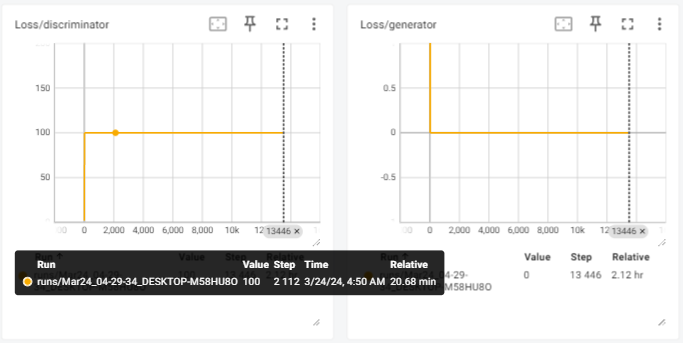

# Max Poool and Avg Pool

Добавление MaxPool или AvgPool в дискриминатор для более медленного обучения дискриминатора, уменьшение количества сверток.

In [46]:
batch_size = 256

In [47]:
dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    drop_last=True,
)

In [48]:
class CSPupBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_=False,
    ):
        super(CSPupBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_

        self.deconv_layer1 = nn.ConvTranspose2d(
            in_channels // 2,
            self.out_channels,
            kernel_size=self.k_size,
            stride=self.stride_,
            padding=self.pad_,
            bias=bias_,
        )

        self.deconv_layer2 = nn.ConvTranspose2d(
            in_channels // 2,
            self.out_channels,
            kernel_size=self.k_size,
            stride=self.stride_,
            padding=self.pad_,
            bias=self.bias_,
        )

        self.conv1 = nn.Conv2d(
            in_channels // 2,
            in_channels // 2,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            self.out_channels,
            self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.relu2 = nn.LeakyReLU(inplace=True)

        self.conv3 = nn.Conv2d(
            self.out_channels,
            self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        first_part = self.deconv_layer1(first_part)

        second_part = self.conv1(second_part)
        second_part = self.relu1(second_part)
        second_part = self.deconv_layer2(second_part)
        second_part = self.conv2(second_part)
        second_part = self.relu2(second_part)
        second_part = self.conv3(second_part)

        return first_part + second_part

In [49]:
class CSPupBlock2(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_,
    ):
        super().__init__()
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_
        self.first = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
        )
        self.second = nn.Sequential(
            nn.Conv2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        return self.first(first_part) + self.second(second_part)

In [50]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            CSPupBlock2(
                latent_dim,
                1024,
                k_size=4,
                stride_=1,
                pad_=0,
                bias_=False,
            ),
            CSPupBlock2(
                1024,
                512,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                512,
                256,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                256,
                128,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                128,
                64,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            nn.ConvTranspose2d(
                64,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.ReLU(inplace=True),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.main(z.view(z.size(0), z.size(1), 1, 1))

In [51]:
G = Generator(100)
G.apply(weights_init)
G.cuda()

Generator(
  (main): Sequential(
    (0): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(50, 1024, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): LeakyReLU(negative_slope=0.1)
        (7): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (second): Sequential(


In [52]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Conv2d(
            #     64,
            #     128,
            #     kernel_size=4,
            #     stride=2,
            #     padding=1,
            #     bias=False,
            # ),
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.1, inplace=True),
            # nn.MaxPool2d(
            #     kernel_size=4,
            #     stride=2,
            #     padding=1,
            # ),
            nn.AvgPool2d(
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Conv2d(
                64,
                256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.Conv2d(
            #     128,
            #     256,
            #     kernel_size=4,
            #     stride=2,
            #     padding=1,
            #     bias=False,
            # ),
            # nn.BatchNorm2d(256),
            # nn.LeakyReLU(0.1, inplace=True),
            # nn.Conv2d(
            #     256,
            #     512,
            #     kernel_size=4,
            #     stride=2,
            #     padding=1,
            #     bias=False,
            # ),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.1, inplace=True),
            # nn.MaxPool2d(
            #     kernel_size=4,
            #     stride=2,
            #     padding=1,
            # ),
            nn.AvgPool2d(
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Conv2d(
                256,
                1024,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.Conv2d(
            #     512,
            #     1024,
            #     kernel_size=4,
            #     stride=2,
            #     padding=1,
            #     bias=False,
            # ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                1024,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, img):
        _ = self.main(img)
        return _.view(-1)


D = Discriminator()
D.apply(weights_init)
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): AvgPool2d(kernel_size=4, stride=2, padding=1)
    (4): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): AvgPool2d(kernel_size=4, stride=2, padding=1)
    (6): Conv2d(256, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)

In [53]:
writer = SummaryWriter()

In [54]:
def wasserstein_loss(real, fake):
    loss = -torch.mean(fake) + torch.mean(real)
    return loss

In [55]:
def train(
    generator,
    discriminator,
    dataloader,
    latent_dim,
    num_epochs,
    g_lr,
    d_lr,
    g_wd,
    d_wd,
    beta1,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    opt_gen = optim.AdamW(
        generator.parameters(),
        lr=g_lr,
        betas=(beta1, 0.999),
        weight_decay=g_wd,
    )
    opt_disc = optim.AdamW(
        discriminator.parameters(),
        lr=d_lr,
        weight_decay=d_wd,
    )

    criterion = nn.BCELoss().cuda()
    # criterion = wasserstein_loss

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(tqdm.tqdm(dataloader)):
            imgs = imgs.to(device)
            # valid = torch.ones(imgs.size(0), 1).to(device)
            valid = torch.full(
                (imgs.size(0),), 1.0, dtype=torch.float, device=device
            )
            # fake = torch.zeros(imgs.size(0), 1).to(device)
            fake = torch.full(
                (imgs.size(0),), 0.0, dtype=torch.float, device=device
            )

            noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            fake_imgs = generator(noise)

            # if epoch % 2 == 0:
            opt_disc.zero_grad()
            output = discriminator(imgs)
            errD_real = criterion(output, valid)
            errD_real.backward(retain_graph=True)

            # noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            # fake_imgs = generator(noise)

            output = discriminator(fake_imgs)
            errD_fake = criterion(output, fake)
            errD_fake.backward(retain_graph=True)

            errD = errD_real + errD_fake
            opt_disc.step()
            if i % 10 == 0:
                writer.add_scalar(
                    "Loss/discriminator",
                    errD.item(),
                    len(data_loader) * epoch + i,
                )

            opt_gen.zero_grad()
            output = discriminator(fake_imgs)
            errG = criterion(output, valid)
            errG.backward()
            opt_gen.step()
            if i % 10 == 0:
                generator.eval()
                fake_imgs = generator(fixed_noise).detach().cpu()
                save_image(
                    fake_imgs,
                    f"samples4/fake_images-{epoch}-{i}.png",
                    nrow=8,
                )
                generator.train()
                writer.add_scalar(
                    "Loss/generator",
                    errG.item(),
                    len(data_loader) * epoch + i,
                )
                grid = make_grid(fake_imgs, padding=2, normalize=True)
                writer.add_image("gen_img_vis", grid, i)
            if i % 100 == 0:
                print(
                    f"Iter {i} on epoch_{epoch} | d_loss: {errD.item()} | g_loss: {errG.item()}"
                )
        # print(
        #     f"Epoch {epoch}/{num_epochs} | d_loss: {errD.item()} | g_loss: {errG.item()}"
        # )

        generator.eval()
        fake_imgs = generator(fixed_noise).detach().cpu()
        save_image(fake_imgs, f"samples4/fake_images-{epoch}.png", nrow=8)
        generator.train()

In [47]:
train(
    G,
    D,
    data_loader,
    latent_dim=100,
    num_epochs=17,
    d_lr=0.0002,
    g_lr=0.0002,
    d_wd=0.01,
    g_wd=0.4,
    beta1=0.5,
)

  0%|          | 1/791 [00:02<29:11,  2.22s/it]

Iter 0 on epoch_0 | d_loss: 1.943629264831543 | g_loss: 18.640399932861328


  4%|▎         | 29/791 [00:16<05:40,  2.24it/s]

 13%|█▎        | 101/791 [00:54<10:10,  1.13it/s]

Iter 100 on epoch_0 | d_loss: 9.441569328308105 | g_loss: 0.12897524237632751


 25%|██▌       | 201/791 [01:47<08:21,  1.18it/s]

Iter 200 on epoch_0 | d_loss: 3.003021240234375 | g_loss: 1.194263219833374


 38%|███▊      | 301/791 [02:38<07:25,  1.10it/s]

Iter 300 on epoch_0 | d_loss: 4.3918304443359375 | g_loss: 0.18236666917800903


 51%|█████     | 401/791 [03:34<04:32,  1.43it/s]

Iter 400 on epoch_0 | d_loss: 2.7506484985351562 | g_loss: 0.7700352668762207


 63%|██████▎   | 501/791 [04:25<03:39,  1.32it/s]

Iter 500 on epoch_0 | d_loss: 2.1607651710510254 | g_loss: 0.7161171436309814


 76%|███████▌  | 601/791 [05:21<03:33,  1.12s/it]

Iter 600 on epoch_0 | d_loss: 2.5061545372009277 | g_loss: 0.4187983572483063


 89%|████████▊ | 701/791 [06:11<01:05,  1.38it/s]

Iter 700 on epoch_0 | d_loss: 2.534566640853882 | g_loss: 0.6826192736625671


  0%|          | 1/791 [00:02<30:59,  2.35s/it]

Iter 0 on epoch_1 | d_loss: 2.422786235809326 | g_loss: 0.622551441192627


 13%|█▎        | 101/791 [00:52<08:54,  1.29it/s]

Iter 100 on epoch_1 | d_loss: 2.364816188812256 | g_loss: 0.3909684419631958


 25%|██▌       | 201/791 [01:50<08:02,  1.22it/s]

Iter 200 on epoch_1 | d_loss: 2.134197235107422 | g_loss: 0.5064980387687683


 38%|███▊      | 301/791 [02:42<06:30,  1.26it/s]

Iter 300 on epoch_1 | d_loss: 1.7595701217651367 | g_loss: 0.6868062615394592


 51%|█████     | 401/791 [03:33<05:04,  1.28it/s]

Iter 400 on epoch_1 | d_loss: 1.1407794952392578 | g_loss: 1.9788191318511963


 63%|██████▎   | 501/791 [04:22<03:28,  1.39it/s]

Iter 500 on epoch_1 | d_loss: 1.9031823873519897 | g_loss: 0.5476689338684082


 76%|███████▌  | 601/791 [05:16<03:20,  1.05s/it]

Iter 600 on epoch_1 | d_loss: 2.0898852348327637 | g_loss: 0.7347034215927124


 89%|████████▊ | 701/791 [06:09<01:07,  1.34it/s]

Iter 700 on epoch_1 | d_loss: 2.067497968673706 | g_loss: 0.6805713772773743


  0%|          | 1/791 [00:02<29:27,  2.24s/it]

Iter 0 on epoch_2 | d_loss: 1.9698094129562378 | g_loss: 0.6127277612686157


 13%|█▎        | 101/791 [00:53<11:19,  1.02it/s]

Iter 100 on epoch_2 | d_loss: 1.9177926778793335 | g_loss: 0.6561500430107117


 25%|██▌       | 201/791 [01:45<07:46,  1.26it/s]

Iter 200 on epoch_2 | d_loss: 2.386915922164917 | g_loss: 0.6188014149665833


 38%|███▊      | 301/791 [02:37<05:51,  1.39it/s]

Iter 300 on epoch_2 | d_loss: 1.8218166828155518 | g_loss: 0.6545813083648682


 51%|█████     | 401/791 [03:27<04:54,  1.32it/s]

Iter 400 on epoch_2 | d_loss: 1.6987605094909668 | g_loss: 0.7138892412185669


 63%|██████▎   | 501/791 [04:16<04:37,  1.04it/s]

Iter 500 on epoch_2 | d_loss: 2.1478493213653564 | g_loss: 0.6530636548995972


 76%|███████▌  | 601/791 [05:04<02:15,  1.40it/s]

Iter 600 on epoch_2 | d_loss: 1.98060941696167 | g_loss: 0.5098923444747925


 89%|████████▊ | 701/791 [05:55<01:04,  1.39it/s]

Iter 700 on epoch_2 | d_loss: 1.6509513854980469 | g_loss: 1.2843923568725586


  0%|          | 1/791 [00:02<31:04,  2.36s/it]

Iter 0 on epoch_3 | d_loss: 2.0803489685058594 | g_loss: 0.4742022454738617


 13%|█▎        | 101/791 [00:55<09:07,  1.26it/s]

Iter 100 on epoch_3 | d_loss: 2.206925630569458 | g_loss: 0.55440753698349


 25%|██▌       | 201/791 [01:48<07:27,  1.32it/s]

Iter 200 on epoch_3 | d_loss: 2.268096685409546 | g_loss: 0.7564001083374023


 38%|███▊      | 301/791 [02:39<06:11,  1.32it/s]

Iter 300 on epoch_3 | d_loss: 2.128038167953491 | g_loss: 0.7070305943489075


 51%|█████     | 401/791 [03:31<04:48,  1.35it/s]

Iter 400 on epoch_3 | d_loss: 1.997687816619873 | g_loss: 0.5421894788742065


 63%|██████▎   | 501/791 [04:22<04:11,  1.15it/s]

Iter 500 on epoch_3 | d_loss: 2.107630968093872 | g_loss: 0.6016871333122253


 76%|███████▌  | 601/791 [05:15<02:57,  1.07it/s]

Iter 600 on epoch_3 | d_loss: 1.8381543159484863 | g_loss: 0.634078323841095


 89%|████████▊ | 701/791 [06:06<01:14,  1.21it/s]

Iter 700 on epoch_3 | d_loss: 1.857853651046753 | g_loss: 0.5741308331489563


  0%|          | 1/791 [00:02<27:05,  2.06s/it]

Iter 0 on epoch_4 | d_loss: 1.8043889999389648 | g_loss: 0.4748784899711609


 13%|█▎        | 101/791 [00:52<07:50,  1.47it/s]

Iter 100 on epoch_4 | d_loss: 1.8238730430603027 | g_loss: 0.6785131096839905


 25%|██▌       | 201/791 [01:41<08:52,  1.11it/s]

Iter 200 on epoch_4 | d_loss: 1.9193999767303467 | g_loss: 0.5224760174751282


 38%|███▊      | 301/791 [02:30<06:41,  1.22it/s]

Iter 300 on epoch_4 | d_loss: 1.8115754127502441 | g_loss: 0.5244693756103516


 51%|█████     | 401/791 [03:25<04:41,  1.39it/s]

Iter 400 on epoch_4 | d_loss: 1.9296090602874756 | g_loss: 0.4789867401123047


 63%|██████▎   | 501/791 [04:19<03:16,  1.48it/s]

Iter 500 on epoch_4 | d_loss: 2.0274693965911865 | g_loss: 1.0654792785644531


 76%|███████▌  | 601/791 [05:11<02:23,  1.32it/s]

Iter 600 on epoch_4 | d_loss: 1.9624500274658203 | g_loss: 0.6582383513450623


 89%|████████▊ | 701/791 [06:02<01:03,  1.42it/s]

Iter 700 on epoch_4 | d_loss: 1.6939914226531982 | g_loss: 0.6058751940727234


  0%|          | 1/791 [00:02<27:52,  2.12s/it]

Iter 0 on epoch_5 | d_loss: 1.7110967636108398 | g_loss: 0.5460937023162842


 13%|█▎        | 101/791 [00:53<08:09,  1.41it/s]

Iter 100 on epoch_5 | d_loss: 1.7567218542099 | g_loss: 0.5979673862457275


 25%|██▌       | 201/791 [01:44<09:24,  1.04it/s]

Iter 200 on epoch_5 | d_loss: 1.676459789276123 | g_loss: 0.6605949401855469


 38%|███▊      | 301/791 [02:40<06:03,  1.35it/s]

Iter 300 on epoch_5 | d_loss: 1.9135406017303467 | g_loss: 0.8982535600662231


 51%|█████     | 401/791 [03:31<04:46,  1.36it/s]

Iter 400 on epoch_5 | d_loss: 1.7803760766983032 | g_loss: 0.5020047426223755


 63%|██████▎   | 501/791 [04:20<03:29,  1.39it/s]

Iter 500 on epoch_5 | d_loss: 1.8965187072753906 | g_loss: 0.6770635843276978


 76%|███████▌  | 601/791 [05:10<02:16,  1.39it/s]

Iter 600 on epoch_5 | d_loss: 1.3526586294174194 | g_loss: 0.6827872395515442


 89%|████████▊ | 701/791 [06:01<01:18,  1.14it/s]

Iter 700 on epoch_5 | d_loss: 1.8291910886764526 | g_loss: 0.43632566928863525


  0%|          | 1/791 [00:02<28:45,  2.18s/it]

Iter 0 on epoch_6 | d_loss: 2.037365436553955 | g_loss: 0.5482232570648193


 13%|█▎        | 101/791 [00:54<08:23,  1.37it/s]

Iter 100 on epoch_6 | d_loss: 2.0527048110961914 | g_loss: 0.9917932748794556


 25%|██▌       | 201/791 [01:45<06:37,  1.48it/s]

Iter 200 on epoch_6 | d_loss: 1.798688292503357 | g_loss: 0.5388820171356201


 38%|███▊      | 301/791 [02:35<07:13,  1.13it/s]

Iter 300 on epoch_6 | d_loss: 1.7398099899291992 | g_loss: 0.6260521411895752


 51%|█████     | 401/791 [03:27<05:22,  1.21it/s]

Iter 400 on epoch_6 | d_loss: 2.124760150909424 | g_loss: 0.816972017288208


 63%|██████▎   | 501/791 [04:18<04:26,  1.09it/s]

Iter 500 on epoch_6 | d_loss: 1.629887580871582 | g_loss: 0.639922022819519


 76%|███████▌  | 601/791 [05:08<02:13,  1.42it/s]

Iter 600 on epoch_6 | d_loss: 1.8170466423034668 | g_loss: 0.5097538232803345


 89%|████████▊ | 701/791 [06:03<01:12,  1.25it/s]

Iter 700 on epoch_6 | d_loss: 1.7195879220962524 | g_loss: 0.6105411052703857


  0%|          | 1/791 [00:02<36:30,  2.77s/it]

Iter 0 on epoch_7 | d_loss: 2.174058437347412 | g_loss: 1.1706230640411377


 13%|█▎        | 101/791 [00:54<10:25,  1.10it/s]

Iter 100 on epoch_7 | d_loss: 2.048945903778076 | g_loss: 0.7466922998428345


 25%|██▌       | 201/791 [01:44<07:57,  1.24it/s]

Iter 200 on epoch_7 | d_loss: 1.015223503112793 | g_loss: 1.6733131408691406


 38%|███▊      | 302/791 [02:32<03:38,  2.24it/s]

Iter 300 on epoch_7 | d_loss: 0.05556424707174301 | g_loss: 4.703929901123047


 51%|█████     | 401/791 [03:15<03:56,  1.65it/s]

Iter 400 on epoch_7 | d_loss: 0.04942445084452629 | g_loss: 6.472047328948975


 63%|██████▎   | 501/791 [04:00<02:47,  1.73it/s]

Iter 500 on epoch_7 | d_loss: 0.599972128868103 | g_loss: 11.564324378967285


 76%|███████▌  | 601/791 [04:40<02:08,  1.48it/s]

Iter 600 on epoch_7 | d_loss: 0.015267440117895603 | g_loss: 4.603734493255615


 89%|████████▊ | 701/791 [05:16<00:48,  1.87it/s]

Iter 700 on epoch_7 | d_loss: 0.008235154673457146 | g_loss: 7.965179443359375


  0%|          | 1/791 [00:01<21:28,  1.63s/it]

Iter 0 on epoch_8 | d_loss: 0.0220993272960186 | g_loss: 5.326844692230225


 13%|█▎        | 101/791 [00:42<06:43,  1.71it/s]

Iter 100 on epoch_8 | d_loss: 0.0013038677861914039 | g_loss: 7.378422737121582


 25%|██▌       | 201/791 [01:21<06:47,  1.45it/s]

Iter 200 on epoch_8 | d_loss: 0.0007230929913930595 | g_loss: 9.060066223144531


 38%|███▊      | 301/791 [02:05<04:32,  1.80it/s]

Iter 300 on epoch_8 | d_loss: 0.0011630072258412838 | g_loss: 9.955253601074219


 51%|█████     | 401/791 [02:42<03:44,  1.74it/s]

Iter 400 on epoch_8 | d_loss: 0.0005247688968665898 | g_loss: 10.411785125732422


 63%|██████▎   | 501/791 [03:22<02:50,  1.71it/s]

Iter 500 on epoch_8 | d_loss: 0.0003305681748315692 | g_loss: 10.733013153076172


 76%|███████▌  | 601/791 [04:02<01:42,  1.85it/s]

Iter 600 on epoch_8 | d_loss: 0.000334303971612826 | g_loss: 10.994932174682617


 89%|████████▊ | 701/791 [04:47<01:06,  1.35it/s]

Iter 700 on epoch_8 | d_loss: 0.0001326847414020449 | g_loss: 11.248091697692871


  0%|          | 1/791 [00:02<28:11,  2.14s/it]

Iter 0 on epoch_9 | d_loss: 0.00016814186528790742 | g_loss: 11.388799667358398


 13%|█▎        | 101/791 [00:41<06:50,  1.68it/s]

Iter 100 on epoch_9 | d_loss: 0.00028220139211043715 | g_loss: 8.725709915161133


 25%|██▌       | 201/791 [01:21<05:27,  1.80it/s]

Iter 200 on epoch_9 | d_loss: 0.04572741687297821 | g_loss: 3.6442391872406006


 38%|███▊      | 301/791 [02:03<05:48,  1.41it/s]

Iter 300 on epoch_9 | d_loss: 0.0025176771450787783 | g_loss: 7.739517688751221


 51%|█████     | 401/791 [02:44<04:18,  1.51it/s]

Iter 400 on epoch_9 | d_loss: 0.0008031594334170222 | g_loss: 9.425859451293945


 63%|██████▎   | 501/791 [03:30<03:31,  1.37it/s]

Iter 500 on epoch_9 | d_loss: 0.0017325265798717737 | g_loss: 9.168055534362793


 76%|███████▌  | 601/791 [04:20<02:38,  1.20it/s]

Iter 600 on epoch_9 | d_loss: 0.00190555932931602 | g_loss: 6.976175308227539


 89%|████████▊ | 701/791 [05:13<01:10,  1.27it/s]

Iter 700 on epoch_9 | d_loss: 3.1256539821624756 | g_loss: 1.750103235244751


  0%|          | 1/791 [00:03<43:27,  3.30s/it]

Iter 0 on epoch_10 | d_loss: 3.237300157546997 | g_loss: 0.6536692380905151


 13%|█▎        | 101/791 [00:55<09:48,  1.17it/s]

Iter 100 on epoch_10 | d_loss: 2.4511313438415527 | g_loss: 0.46482381224632263


 25%|██▌       | 201/791 [01:48<07:09,  1.37it/s]

Iter 200 on epoch_10 | d_loss: 2.406000852584839 | g_loss: 0.737841010093689


 38%|███▊      | 301/791 [02:38<06:14,  1.31it/s]

Iter 300 on epoch_10 | d_loss: 1.962085485458374 | g_loss: 0.5829312205314636


 51%|█████     | 401/791 [03:32<04:29,  1.45it/s]

Iter 400 on epoch_10 | d_loss: 1.8665528297424316 | g_loss: 0.5856374502182007


 63%|██████▎   | 501/791 [04:22<03:38,  1.33it/s]

Iter 500 on epoch_10 | d_loss: 1.8385924100875854 | g_loss: 0.5861758589744568


 76%|███████▌  | 601/791 [05:13<02:22,  1.33it/s]

Iter 600 on epoch_10 | d_loss: 2.9170308113098145 | g_loss: 0.7279471158981323


 89%|████████▊ | 701/791 [06:07<01:20,  1.12it/s]

Iter 700 on epoch_10 | d_loss: 3.9670989513397217 | g_loss: 0.6116965413093567


  0%|          | 1/791 [00:02<31:11,  2.37s/it]

Iter 0 on epoch_11 | d_loss: 2.083400249481201 | g_loss: 0.7443954944610596


 13%|█▎        | 101/791 [00:55<08:01,  1.43it/s]

Iter 100 on epoch_11 | d_loss: 1.8851613998413086 | g_loss: 0.6423242092132568


 25%|██▌       | 201/791 [01:48<07:51,  1.25it/s]

Iter 200 on epoch_11 | d_loss: 1.6944246292114258 | g_loss: 0.6091272234916687


 38%|███▊      | 301/791 [02:40<05:34,  1.46it/s]

Iter 300 on epoch_11 | d_loss: 1.4724252223968506 | g_loss: 0.7430212497711182


 51%|█████     | 401/791 [03:32<05:19,  1.22it/s]

Iter 400 on epoch_11 | d_loss: 1.560044527053833 | g_loss: 0.6495503783226013


 63%|██████▎   | 501/791 [04:23<03:32,  1.36it/s]

Iter 500 on epoch_11 | d_loss: 1.4753845930099487 | g_loss: 0.7124701738357544


 76%|███████▌  | 601/791 [05:12<02:34,  1.23it/s]

Iter 600 on epoch_11 | d_loss: 1.814176321029663 | g_loss: 0.6589730978012085


 89%|████████▊ | 701/791 [06:03<01:10,  1.27it/s]

Iter 700 on epoch_11 | d_loss: 1.6442395448684692 | g_loss: 0.6611709594726562


  0%|          | 1/791 [00:02<28:49,  2.19s/it]

Iter 0 on epoch_12 | d_loss: 1.7126129865646362 | g_loss: 0.6434217095375061


 13%|█▎        | 101/791 [00:50<07:58,  1.44it/s]

Iter 100 on epoch_12 | d_loss: 1.5761735439300537 | g_loss: 0.6616556644439697


 25%|██▌       | 201/791 [01:40<08:23,  1.17it/s]

Iter 200 on epoch_12 | d_loss: 1.5375064611434937 | g_loss: 0.6716922521591187


 38%|███▊      | 301/791 [02:29<05:51,  1.40it/s]

Iter 300 on epoch_12 | d_loss: 1.522864818572998 | g_loss: 0.6298340559005737


 51%|█████     | 401/791 [03:16<04:16,  1.52it/s]

Iter 400 on epoch_12 | d_loss: 1.8564889430999756 | g_loss: 0.5318481922149658


 63%|██████▎   | 501/791 [04:07<03:29,  1.39it/s]

Iter 500 on epoch_12 | d_loss: 1.470062017440796 | g_loss: 0.7085623741149902


 76%|███████▌  | 601/791 [04:57<02:20,  1.35it/s]

Iter 600 on epoch_12 | d_loss: 1.6156182289123535 | g_loss: 0.6281604170799255


 89%|████████▊ | 701/791 [05:48<01:21,  1.10it/s]

Iter 700 on epoch_12 | d_loss: 1.6638563871383667 | g_loss: 0.6416614055633545


  0%|          | 1/791 [00:02<28:35,  2.17s/it]

Iter 0 on epoch_13 | d_loss: 1.5335369110107422 | g_loss: 0.7171651124954224


 13%|█▎        | 101/791 [00:54<09:04,  1.27it/s]

Iter 100 on epoch_13 | d_loss: 1.596388816833496 | g_loss: 0.673554539680481


 25%|██▌       | 201/791 [01:47<06:51,  1.43it/s]

Iter 200 on epoch_13 | d_loss: 1.5530141592025757 | g_loss: 0.6472858786582947


 38%|███▊      | 301/791 [02:39<09:01,  1.10s/it]

Iter 300 on epoch_13 | d_loss: 1.64011549949646 | g_loss: 0.6886277794837952


 51%|█████     | 401/791 [03:32<05:33,  1.17it/s]

Iter 400 on epoch_13 | d_loss: 1.4877910614013672 | g_loss: 0.6585613489151001


 63%|██████▎   | 501/791 [04:25<04:42,  1.03it/s]

Iter 500 on epoch_13 | d_loss: 1.5140042304992676 | g_loss: 0.6611388325691223


 76%|███████▌  | 601/791 [05:19<02:34,  1.23it/s]

Iter 600 on epoch_13 | d_loss: 1.498629093170166 | g_loss: 0.7018458843231201


 89%|████████▊ | 701/791 [06:10<01:20,  1.12it/s]

Iter 700 on epoch_13 | d_loss: 1.542426347732544 | g_loss: 0.6495050191879272


  0%|          | 1/791 [00:02<28:40,  2.18s/it]

Iter 0 on epoch_14 | d_loss: 1.4693973064422607 | g_loss: 0.6476256847381592


 13%|█▎        | 101/791 [00:52<08:34,  1.34it/s]

Iter 100 on epoch_14 | d_loss: 1.5487629175186157 | g_loss: 0.6201574802398682


 25%|██▌       | 201/791 [01:43<07:02,  1.40it/s]

Iter 200 on epoch_14 | d_loss: 1.61117422580719 | g_loss: 0.6025183200836182


 38%|███▊      | 301/791 [02:34<06:13,  1.31it/s]

Iter 300 on epoch_14 | d_loss: 1.4731645584106445 | g_loss: 0.6904798746109009


 51%|█████     | 401/791 [03:28<06:15,  1.04it/s]

Iter 400 on epoch_14 | d_loss: 1.469031810760498 | g_loss: 0.6804847121238708


 63%|██████▎   | 501/791 [04:18<03:36,  1.34it/s]

Iter 500 on epoch_14 | d_loss: 1.5410740375518799 | g_loss: 0.6567465662956238


 76%|███████▌  | 601/791 [05:12<02:10,  1.46it/s]

Iter 600 on epoch_14 | d_loss: 1.4682512283325195 | g_loss: 0.6594005823135376


 89%|████████▊ | 701/791 [06:02<01:02,  1.44it/s]

Iter 700 on epoch_14 | d_loss: 1.515238642692566 | g_loss: 0.6584265828132629


  0%|          | 1/791 [00:02<29:47,  2.26s/it]

Iter 0 on epoch_15 | d_loss: 1.5183687210083008 | g_loss: 0.6740353107452393


 13%|█▎        | 101/791 [00:53<07:32,  1.52it/s]

Iter 100 on epoch_15 | d_loss: 1.4549808502197266 | g_loss: 0.6860524415969849


 25%|██▌       | 201/791 [01:43<07:15,  1.36it/s]

Iter 200 on epoch_15 | d_loss: 1.4583227634429932 | g_loss: 0.6704707741737366


 38%|███▊      | 301/791 [02:32<05:45,  1.42it/s]

Iter 300 on epoch_15 | d_loss: 1.468434453010559 | g_loss: 0.6810406446456909


 51%|█████     | 401/791 [03:22<04:16,  1.52it/s]

Iter 400 on epoch_15 | d_loss: 1.4237675666809082 | g_loss: 0.6832744479179382


 63%|██████▎   | 501/791 [04:15<03:51,  1.25it/s]

Iter 500 on epoch_15 | d_loss: 1.4940670728683472 | g_loss: 0.6481392979621887


 76%|███████▌  | 601/791 [05:02<02:18,  1.37it/s]

Iter 600 on epoch_15 | d_loss: 1.4677598476409912 | g_loss: 0.6935883164405823


 89%|████████▊ | 701/791 [05:54<01:07,  1.32it/s]

Iter 700 on epoch_15 | d_loss: 1.4545649290084839 | g_loss: 0.6704867482185364


  0%|          | 1/791 [00:02<29:40,  2.25s/it]

Iter 0 on epoch_16 | d_loss: 1.4223806858062744 | g_loss: 0.6670382022857666


 13%|█▎        | 101/791 [00:50<08:08,  1.41it/s]

Iter 100 on epoch_16 | d_loss: 1.496366024017334 | g_loss: 0.668674647808075


 25%|██▌       | 201/791 [01:42<07:24,  1.33it/s]

Iter 200 on epoch_16 | d_loss: 1.417527675628662 | g_loss: 0.6809599995613098


 38%|███▊      | 301/791 [02:35<05:58,  1.36it/s]

Iter 300 on epoch_16 | d_loss: 1.3990633487701416 | g_loss: 0.7211707830429077


 51%|█████     | 401/791 [03:27<04:12,  1.54it/s]

Iter 400 on epoch_16 | d_loss: 1.4265432357788086 | g_loss: 0.6761538982391357


 63%|██████▎   | 501/791 [04:18<03:14,  1.49it/s]

Iter 500 on epoch_16 | d_loss: 1.456695795059204 | g_loss: 0.660443902015686


 76%|███████▌  | 601/791 [05:11<02:17,  1.38it/s]

Iter 600 on epoch_16 | d_loss: 1.4453067779541016 | g_loss: 0.6847299337387085


 89%|████████▊ | 701/791 [06:04<01:27,  1.03it/s]

Iter 700 on epoch_16 | d_loss: 1.3732731342315674 | g_loss: 0.719444751739502


100%|██████████| 791/791 [06:49<00:00,  1.93it/s]


Результат: самые адекватные предсказания из всех, что предсталвены выше  
По Loss можно сказать, что модель не рухнула, а целенаправленно сходилась, правда, с провалом посередине обучения  
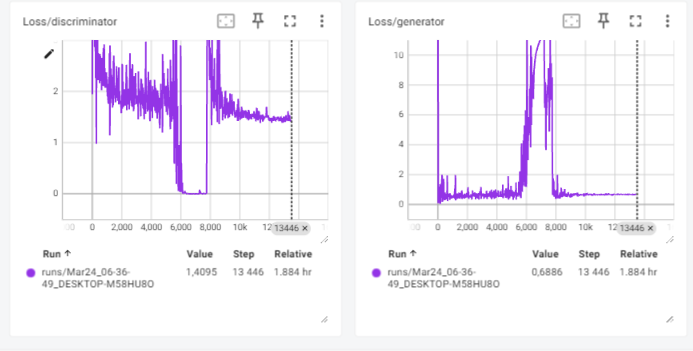

Генерируемые изображенния  
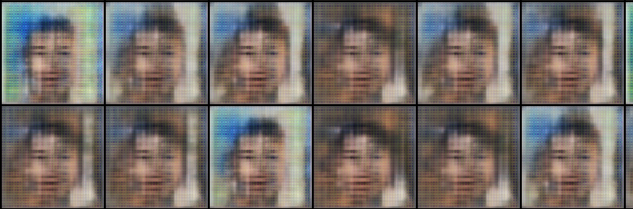  
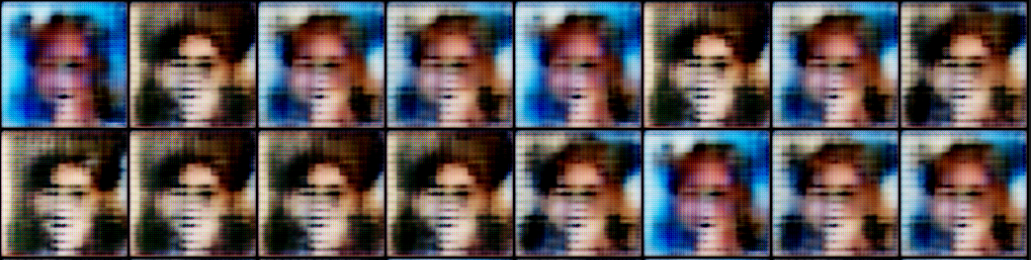

# LR для Discriminator и Generator, кол-во сверток в дискриминаторе и обучение каждые n эпох

1. Провел много экспериментов для подбора LR в Discriminator и Generator, были выбраны эти значения
2. Увеличение кол-ва сверток в дискриминаторе для уменьшения вероятности Mode Collapse
3. Обучение Discriminator каждые n эпох

In [56]:
batch_size = 256

In [57]:
dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    drop_last=True,
)

In [59]:
class CSPupBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_=False,
    ):
        super(CSPupBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_

        self.deconv_layer1 = nn.ConvTranspose2d(
            in_channels // 2,
            self.out_channels,
            kernel_size=self.k_size,
            stride=self.stride_,
            padding=self.pad_,
            bias=bias_,
        )

        self.deconv_layer2 = nn.ConvTranspose2d(
            in_channels // 2,
            self.out_channels,
            kernel_size=self.k_size,
            stride=self.stride_,
            padding=self.pad_,
            bias=self.bias_,
        )

        self.conv1 = nn.Conv2d(
            in_channels // 2,
            in_channels // 2,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            self.out_channels,
            self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.relu2 = nn.LeakyReLU(inplace=True)

        self.conv3 = nn.Conv2d(
            self.out_channels,
            self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        first_part = self.deconv_layer1(first_part)

        second_part = self.conv1(second_part)
        second_part = self.relu1(second_part)
        second_part = self.deconv_layer2(second_part)
        second_part = self.conv2(second_part)
        second_part = self.relu2(second_part)
        second_part = self.conv3(second_part)

        return first_part + second_part

In [60]:
class CSPupBlock2(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        k_size,
        stride_,
        pad_,
        bias_,
    ):
        super().__init__()
        self.k_size = k_size
        self.stride_ = stride_
        self.pad_ = pad_
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_ = bias_
        self.first = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
        )
        self.second = nn.Sequential(
            nn.Conv2d(
                in_channels=self.in_channels // 2,
                out_channels=self.out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=self.k_size,
                stride=self.stride_,
                padding=self.pad_,
                bias=self.bias_,
            ),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=self.out_channels,
                out_channels=self.out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x):
        first_part = x[:, : self.in_channels // 2, ...]
        second_part = x[:, self.in_channels // 2 :, ...]
        return self.first(first_part) + self.second(second_part)

In [61]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            CSPupBlock2(
                latent_dim,
                1024,
                k_size=4,
                stride_=1,
                pad_=0,
                bias_=False,
            ),
            CSPupBlock2(
                1024,
                512,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                512,
                256,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                256,
                128,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            CSPupBlock2(
                128,
                64,
                k_size=4,
                stride_=2,
                pad_=1,
                bias_=False,
            ),
            nn.ConvTranspose2d(
                64,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            # nn.ReLU(inplace=True),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.main(z.view(z.size(0), z.size(1), 1, 1))

In [62]:
G = Generator(100)
G.apply(weights_init)
G.cuda()

Generator(
  (main): Sequential(
    (0): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (second): Sequential(
        (0): Conv2d(50, 1024, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): LeakyReLU(negative_slope=0.1)
        (7): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): CSPupBlock2(
      (first): Sequential(
        (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (second): Sequential(


In [63]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                64,
                128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                128,
                256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                256,
                512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                512,
                768,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                768,
                1024,
                kernel_size=4,
                stride=2,
                padding=3,
                bias=False,
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(
                1024,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, img):
        _ = self.main(img)
        return _.view(-1)


D = Discriminator()
D.apply(weights_init)
D.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(512, 768, kernel_size

In [64]:
writer = SummaryWriter()

In [65]:
def wasserstein_loss(real, fake):
    loss = -torch.mean(fake) + torch.mean(real)
    return loss

In [66]:
def train(
    generator,
    discriminator,
    dataloader,
    latent_dim,
    num_epochs,
    g_lr,
    d_lr,
    g_wd,
    d_wd,
    beta1,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    fixed_noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    opt_gen = optim.AdamW(
        generator.parameters(),
        lr=g_lr,
        betas=(beta1, 0.999),
        weight_decay=g_wd,
    )
    opt_disc = optim.AdamW(
        discriminator.parameters(),
        lr=d_lr,
        weight_decay=d_wd,
    )

    criterion = nn.BCELoss().cuda()
    # criterion = wasserstein_loss

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(tqdm.tqdm(dataloader)):
            imgs = imgs.to(device)
            # valid = torch.ones(imgs.size(0), 1).to(device)
            valid = torch.full(
                (imgs.size(0),), 1.0, dtype=torch.float, device=device
            )
            # fake = torch.zeros(imgs.size(0), 1).to(device)
            fake = torch.full(
                (imgs.size(0),), 0.0, dtype=torch.float, device=device
            )

            noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
            fake_imgs = generator(noise)

            if epoch % 2 == 0:
                opt_disc.zero_grad()
                output = discriminator(imgs)
                errD_real = criterion(output, valid)
                errD_real.backward(retain_graph=True)

                # noise = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
                # fake_imgs = generator(noise)

                output = discriminator(fake_imgs)
                errD_fake = criterion(output, fake)
                errD_fake.backward(retain_graph=True)

                errD = errD_real + errD_fake
                opt_disc.step()
                if i % 10 == 0:
                    writer.add_scalar(
                        "Loss/discriminator",
                        errD.item(),
                        len(data_loader) * epoch + i,
                    )

            opt_gen.zero_grad()
            output = discriminator(fake_imgs)
            errG = criterion(output, valid)
            errG.backward()
            opt_gen.step()
            if i % 10 == 0:
                generator.eval()
                fake_imgs = generator(fixed_noise).detach().cpu()
                save_image(
                    fake_imgs,
                    f"samples5/fake_images-{epoch}-{i}.png",
                    nrow=8,
                )
                generator.train()
                writer.add_scalar(
                    "Loss/generator",
                    errG.item(),
                    len(data_loader) * epoch + i,
                )
                grid = make_grid(fake_imgs, padding=2, normalize=True)
                writer.add_image("gen_img_vis", grid, i)
            if i % 100 == 0:
                print(
                    f"Iter {i} on epoch_{epoch} | d_loss: {errD.item()} | g_loss: {errG.item()}"
                )
        # print(
        #     f"Epoch {epoch}/{num_epochs} | d_loss: {errD.item()} | g_loss: {errG.item()}"
        # )

        generator.eval()
        fake_imgs = generator(fixed_noise).detach().cpu()
        save_image(fake_imgs, f"samples5/fake_images-{epoch}.png", nrow=8)
        generator.train()

In [58]:
train(
    G,
    D,
    data_loader,
    latent_dim=100,
    num_epochs=17,
    d_lr=0.0001,
    g_lr=0.0002,
    d_wd=0.01,
    g_wd=0.4,
    beta1=0.5,
)

  0%|          | 1/791 [00:02<32:33,  2.47s/it]

Iter 0 on epoch_0 | d_loss: 1.7258026599884033 | g_loss: 0.14617133140563965


  1%|          | 8/791 [00:09<12:54,  1.01it/s]

 13%|█▎        | 101/791 [02:11<22:35,  1.96s/it]

Iter 100 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:28<23:21,  2.38s/it]

Iter 200 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:42<13:20,  1.63s/it]

Iter 300 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:47<11:59,  1.84s/it]

Iter 400 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [11:01<09:43,  2.01s/it]

Iter 500 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [13:09<05:07,  1.62s/it]

Iter 600 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [15:17<03:29,  2.33s/it]

Iter 700 on epoch_0 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<38:39,  2.94s/it]

Iter 0 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:54<10:11,  1.13it/s]

Iter 100 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:46<08:51,  1.11it/s]

Iter 200 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:38<07:12,  1.13it/s]

Iter 300 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:29<05:52,  1.11it/s]

Iter 400 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:21<04:14,  1.14it/s]

Iter 500 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:12<02:49,  1.12it/s]

Iter 600 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:04<01:18,  1.14it/s]

Iter 700 on epoch_1 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:03<42:54,  3.26s/it]

Iter 0 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:09<25:44,  2.24s/it]

Iter 100 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:35<17:30,  1.78s/it]

Iter 200 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:48<11:58,  1.47s/it]

Iter 300 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:47<09:35,  1.48s/it]

Iter 400 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:59<11:33,  2.39s/it]

Iter 500 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [13:15<06:07,  1.94s/it]

Iter 600 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [15:25<02:43,  1.82s/it]

Iter 700 on epoch_2 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<38:08,  2.90s/it]

Iter 0 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:50<09:24,  1.22it/s]

Iter 100 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:37<07:56,  1.24it/s]

Iter 200 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:24<06:44,  1.21it/s]

Iter 300 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:12<05:21,  1.21it/s]

Iter 400 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:00<04:02,  1.20it/s]

Iter 500 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [04:47<02:37,  1.20it/s]

Iter 600 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [05:34<01:14,  1.21it/s]

Iter 700 on epoch_3 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:03<42:46,  3.25s/it]

Iter 0 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:18<25:24,  2.21s/it]

Iter 100 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:29<15:19,  1.56s/it]

Iter 200 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:37<20:50,  2.55s/it]

Iter 300 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:47<10:06,  1.56s/it]

Iter 400 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:59<11:20,  2.35s/it]

Iter 500 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [13:16<06:29,  2.05s/it]

Iter 600 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [15:23<02:55,  1.95s/it]

Iter 700 on epoch_4 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<38:47,  2.95s/it]

Iter 0 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:51<09:33,  1.20it/s]

Iter 100 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:39<08:08,  1.21it/s]

Iter 200 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:26<06:41,  1.22it/s]

Iter 300 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:14<05:20,  1.22it/s]

Iter 400 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:01<03:58,  1.21it/s]

Iter 500 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [04:49<02:36,  1.21it/s]

Iter 600 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [05:36<01:14,  1.21it/s]

Iter 700 on epoch_5 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:04<1:00:45,  4.61s/it]

Iter 0 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:26<21:26,  1.87s/it]

Iter 100 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:33<16:57,  1.72s/it]

Iter 200 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:46<16:50,  2.06s/it]

Iter 300 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:56<12:13,  1.88s/it]

Iter 400 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [11:04<08:05,  1.67s/it]

Iter 500 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [13:16<06:16,  1.98s/it]

Iter 600 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [15:29<03:03,  2.04s/it]

Iter 700 on epoch_6 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<35:32,  2.70s/it]

Iter 0 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:44<08:16,  1.39it/s]

Iter 100 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:26<06:59,  1.41it/s]

Iter 200 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:07<05:48,  1.40it/s]

Iter 300 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:49<04:39,  1.39it/s]

Iter 400 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [03:31<03:23,  1.42it/s]

Iter 500 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [04:12<02:13,  1.43it/s]

Iter 600 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [04:53<01:01,  1.45it/s]

Iter 700 on epoch_7 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:03<46:02,  3.50s/it]

Iter 0 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:10<27:19,  2.38s/it]

Iter 100 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:07<12:52,  1.31s/it]

Iter 200 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:16<14:36,  1.79s/it]

Iter 300 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:17<11:05,  1.71s/it]

Iter 400 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:20<08:12,  1.70s/it]

Iter 500 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [12:33<05:06,  1.61s/it]

Iter 600 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [14:44<03:09,  2.11s/it]

Iter 700 on epoch_8 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<38:01,  2.89s/it]

Iter 0 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [01:01<10:46,  1.07it/s]

Iter 100 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [02:00<09:20,  1.05it/s]

Iter 200 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:59<07:39,  1.07it/s]

Iter 300 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:58<06:01,  1.08it/s]

Iter 400 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:57<04:29,  1.07it/s]

Iter 500 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:55<02:54,  1.09it/s]

Iter 600 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:53<01:22,  1.09it/s]

Iter 700 on epoch_9 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:03<40:39,  3.09s/it]

Iter 0 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:16<20:43,  1.80s/it]

Iter 100 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:14<17:09,  1.74s/it]

Iter 200 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:18<16:15,  1.99s/it]

Iter 300 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:28<11:10,  1.72s/it]

Iter 400 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:23<08:48,  1.82s/it]

Iter 500 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [12:34<07:21,  2.32s/it]

Iter 600 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [14:51<02:50,  1.89s/it]

Iter 700 on epoch_10 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<32:58,  2.51s/it]

Iter 0 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:56<09:58,  1.15it/s]

Iter 100 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:50<08:21,  1.18it/s]

Iter 200 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:44<06:53,  1.19it/s]

Iter 300 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [03:38<05:27,  1.19it/s]

Iter 400 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [04:31<04:03,  1.19it/s]

Iter 500 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [05:25<02:37,  1.21it/s]

Iter 600 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [06:18<01:14,  1.21it/s]

Iter 700 on epoch_11 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<37:04,  2.82s/it]

Iter 0 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:09<16:05,  1.40s/it]

Iter 100 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:06<15:45,  1.60s/it]

Iter 200 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:10<10:47,  1.32s/it]

Iter 300 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:05<08:58,  1.38s/it]

Iter 400 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:03<06:56,  1.44s/it]

Iter 500 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [12:08<05:47,  1.83s/it]

Iter 600 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [14:12<02:24,  1.60s/it]

Iter 700 on epoch_12 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:02<26:52,  2.04s/it]

Iter 0 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:43<07:20,  1.57it/s]

Iter 100 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:24<06:16,  1.57it/s]

Iter 200 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:05<05:07,  1.59it/s]

Iter 300 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:45<04:07,  1.58it/s]

Iter 400 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [03:26<02:57,  1.63it/s]

Iter 500 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [04:07<01:58,  1.60it/s]

Iter 600 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [04:47<00:55,  1.63it/s]

Iter 700 on epoch_13 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:03<44:33,  3.38s/it]

Iter 0 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:09<14:49,  1.29s/it]

Iter 100 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:06<18:11,  1.85s/it]

Iter 200 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:20<15:16,  1.87s/it]

Iter 300 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [08:12<08:19,  1.28s/it]

Iter 400 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:11<07:30,  1.55s/it]

Iter 500 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [12:09<05:27,  1.73s/it]

Iter 600 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [14:16<02:31,  1.68s/it]

Iter 700 on epoch_14 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:01<25:55,  1.97s/it]

Iter 0 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [00:43<07:09,  1.61it/s]

Iter 100 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [01:27<06:10,  1.59it/s]

Iter 200 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [02:10<04:56,  1.65it/s]

Iter 300 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [02:52<03:56,  1.65it/s]

Iter 400 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [03:35<02:50,  1.70it/s]

Iter 500 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [04:17<01:52,  1.69it/s]

Iter 600 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [04:59<00:52,  1.71it/s]

Iter 700 on epoch_15 | d_loss: 100.0 | g_loss: 0.0


  0%|          | 1/791 [00:03<46:12,  3.51s/it]

Iter 0 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 13%|█▎        | 101/791 [02:02<20:46,  1.81s/it]

Iter 100 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 25%|██▌       | 201/791 [04:07<16:19,  1.66s/it]

Iter 200 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 38%|███▊      | 301/791 [06:10<11:12,  1.37s/it]

Iter 300 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 51%|█████     | 401/791 [07:58<08:40,  1.33s/it]

Iter 400 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 63%|██████▎   | 501/791 [10:01<06:40,  1.38s/it]

Iter 500 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 76%|███████▌  | 601/791 [12:05<04:37,  1.46s/it]

Iter 600 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


 89%|████████▊ | 701/791 [14:02<02:10,  1.45s/it]

Iter 700 on epoch_16 | d_loss: 100.0 | g_loss: 0.0


100%|██████████| 791/791 [15:49<00:00,  1.20s/it]


Резльутат: эксперимент, к сожалению, провалился

# Дополнительно

Я делал множество экспериментов, выше описаны только самая малость, можно увидеть различные модели, которые сошлись.  
Увы, побороть Mode Collapse не удалось.  
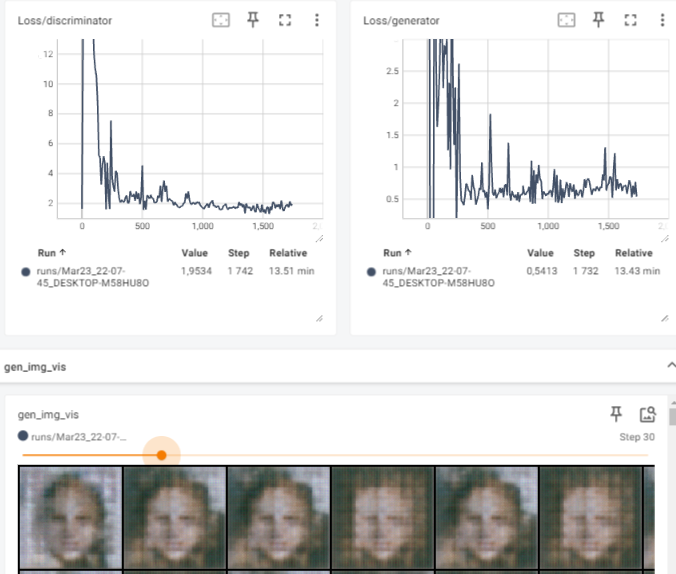

Все запуски и loss'ы можно посмотреть в папке runs

# Итоги

Проведя сверх сотни экспериментов, я могу сказать, что обучение GAN сильно зависит от инициализации весов и рандома в целом.

Если не учитывать Mode Collapse, то считаю, что получение сходимости - есть, изображения генерируются :)